<a href="https://colab.research.google.com/github/daisy-dotcom/pamap2_models/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 3.20.2 which is incompatible.


In [ ]:
!pip install pywavelets

In [ ]:
import os
import numpy as np
from numpy import linalg as LA
from pywt import wavedec
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.model_selection import
import pandas as pd

In [ ]:
pamap2_label_names = [
    'lying',
    'sitting',
    'standing',
    'walking',
    'running',
    'cycling',
    'Nordic_walking',
    'ascending stairs',
    'descending stairs',
    'vacuum_cleaning',
    'ironing',
    'rope_jumping'
]

pamap2_label_num = [1,2,3,4,5,6,7,12,13,16,17,24]

pamap2_updated_labels =[
    'lying',
    'sitting',
    'standing',
    'walking',
    'running',
    'stairs',
]

'''
  1 - lying
  2 - sitting
  3 - standing
  4 - walking
  5 - running
  7 - Nordic_walking  -> changed to the same label as walking
  12 - ascending stairs
  13 - descending stairs

  ascending/descending stais -> just stairs now
'''
labels_to_keep = [1,2,3,4,5,7,12,13]

new_labels = [0,1,2,3,4,5]

In [ ]:
def yaz_feature_eng(batch):
  # time domain features
  # x, y, z mean
  mean = np.mean(batch, axis=0)

  # x, y, z standard deviation
  std = np.std(batch, axis=0)

  # x, y, z 50th percentile
  fifty_th = np.percentile(batch, 50, axis=0)

  # vector magnitude calculated using Frobenius norm
  vec_mag = LA.norm(batch, axis=1)
  vec_mag_mean = np.mean(vec_mag)
  vec_mag_std = np.std(vec_mag)
  vec_mag_50th = np.percentile(vec_mag, 50)

  # frequency domain features extracted using discrete
  # wavelet transforms
  # x, y, z level 1 wave decomposition
  cA1, cD = wavedec(batch, 'db1', level=1, axis=0)

  # x, y, z level 5 wave decomposition
  cA5, cD5, cD4, cD3, cD2, CD1 = wavedec(batch, 'db1', level=5, axis=0)

  # mean of level 1 and 5 approximation coefficients
  cA1_mean = np.mean(cA1, axis=0)
  cA5_mean = np.mean(cA1, axis=0)

  # mean of level 1 and 5 detail coefficients
  cD_mean = np.mean(cD, axis=0)
  cD5_mean = np.mean(cD5, axis=0)

  x_cA_mean_diff = cA1_mean[0] - cA5_mean[0]
  x_cD_mean_diff = cD_mean[0] - cD5_mean[0]

  y_cA_mean_diff = cA1_mean[1] - cA5_mean[1]
  y_cD_mean_diff = cD_mean[1] - cD5_mean[1]

  # 16 features
  features = np.concatenate((mean, std, fifty_th, vec_mag_mean, vec_mag_std, vec_mag_50th,
                             x_cA_mean_diff, x_cD_mean_diff, y_cA_mean_diff, y_cD_mean_diff),axis=None)

  return features

In [ ]:
# Source: Yuan et al. 2024
# Link: https://github.com/OxWearables/ssl-wearables/blob/main/downstream_task_evaluation.py#L483
def yuan_feature_eng(batch, samp_rate=100, window_size=1):
  # time domain features
  # x, y, z mean
  mean = np.mean(batch, axis=0)

  # x, y, z standard deviation
  std = np.std(batch, axis=0)

  # x, y, z range
  range = np.ptp(batch, axis=0)

  # division error handling
  with np.errstate(divide='ignore', invalid='ignore'):
    x, y, z = batch.T
    # 3x3 correlation matrix
    corr = np.nan_to_num(np.corrcoef(batch, rowvar=False))
    corr_xy = np.nan_to_num(np.corrcoef(x,y))[0,1]
    corr_xz = np.nan_to_num(np.corrcoef(x,y))[0,1]
    corr_yz = np.nan_to_num(np.corrcoef(y,z))[0,1]


  # Euclidean norm features
  # mean, standard deviation, range, median
  # absolute deviation, kurtosis and skew
  euclid_norm = LA.norm(batch, axis=1)
  euclid_norm_mean = np.mean(euclid_norm)
  euclid_norm_std = np.std(euclid_norm)
  euclid_norm_range = np.ptp(euclid_norm)
  euclid_norm_mad = stats.median_abs_deviation(euclid_norm)

  if euclid_norm_std > 0.01:
    skew = np.nan_to_num(stats.skew(euclid_norm))
    kurtosis = np.nan_to_num(stats.kurtosis(euclid_norm))
  else:
    skew = kurtosis = 0

  # get true power spectrum because detrend=False
  freqs, powers = signal.welch(
      euclid_norm,
      fs=samp_rate,
      nperseg= samp_rate*window_size,
      noverlap=(2 * samp_rate*window_size) // 3,
      detrend=False,
      average='median')

  with np.errstate(divide="ignore", invalid="ignore"):
        pentropy = np.nan_to_num(stats.entropy(powers + 1e-16))

  # get dominant frequencies
  freqs, powers = signal.welch(
    euclid_norm,
    fs=samp_rate,
    nperseg= samp_rate*window_size,
    noverlap=(2 * samp_rate*window_size) // 3,
    detrend='constant',
    average='median')

  with np.errstate(divide="ignore", invalid="ignore"):
        pentropy = np.nan_to_num(stats.entropy(powers + 1e-16))


  peaks, _ = signal.find_peaks(powers)
  peak_powers = powers[peaks]
  peak_freqs = freqs[peaks]
  peak_ranks = np.argsort(peak_powers)[::-1]
  if len(peaks) >= 2:
      f1 = peak_freqs[peak_ranks[0]]
      f2 = peak_freqs[peak_ranks[1]]
  elif len(peaks) == 1:
      f1 = f2 = peak_freqs[peak_ranks[0]]
  else:
      f1 = f2 = 0

  # 21 features
  features = np.concatenate((mean, std, range, corr_xy, corr_xz, corr_yz,
                             euclid_norm_mean, euclid_norm_std, euclid_norm_range, euclid_norm_mad,
                             skew, kurtosis, pentropy, f1, f2),axis=None)

  return features

In [ ]:
def yuan_yaz(batch, samp_rate=100, window_size=1):
  # Shared Features
  start_yaz = 2
  # 13 feat yuan + 8
  yuan_features = yuan_feature_eng(batch, samp_rate, window_size)
  yaz_features = yaz_feature_eng(batch)

  features = np.concatenate((yuan_features, yaz_features[start_yaz:]),axis=None)

  return features

In [ ]:
def mode_labels(labels, window_size=100):
  # only keep the label and not the count
  return [stats.mode(labels[i:i+window_size])[0] for i in range(0,len(labels),window_size) if len(labels[i:i+window_size]) == window_size]

In [ ]:
def performance_eval(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  precision = metrics.precision_score(y_true, y_pred, average='macro', zero_division=0.0)
  recall = metrics.recall_score(y_true, y_pred, average='macro', zero_division=0.0)
  cohen_kappa = metrics.cohen_kappa_score(y_true, y_pred)
  f1_score = metrics.f1_score(y_true, y_pred, average='macro', zero_division=0.0)
  conf_matrix = confusion_matrix(y_true, y_pred, labels=new_labels, normalize='true')

  return accuracy, precision, recall, cohen_kappa, f1_score, conf_matrix

In [ ]:
def run(data, f_set='yuan'):
  data.loso_groups()

  result = {
      "accuracy": [],
      "precision": [],
      "recall": [],
      "cohen_kappa": [],
      "f1_score": [],
      "conf_matrix": []
  }

  for i in range(len(data.x_train_idx)):
    data.get_train_test_data(data.x_train_idx[i], data.x_test_idx[i])

    # extract features
    data.get_features(f_set=f_set)

    # get window labels
    data.get_mode_labels()

    # random forest
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(data.x_train, data.y_train)
    y_pred = rf.predict(data.x_test)

    accuracy, precision, recall, cohen_kappa, f1_score, conf_matrix = performance_eval(data.y_test, y_pred)

    result["accuracy"].append(accuracy)
    result["precision"].append(precision)
    result["recall"].append(recall)
    result["cohen_kappa"].append(cohen_kappa)
    result["f1_score"].append(f1_score)
    result["conf_matrix"].append(conf_matrix)


  result["accuracy"] = np.mean(result["accuracy"])
  result["precision"] = np.mean(result["precision"], axis=0)
  result["recall"] = np.mean(result["recall"], axis=0)
  result["cohen_kappa"] = np.mean(result["cohen_kappa"], axis=0)
  result["f1_score"] = np.mean(result["f1_score"], axis=0)
  return result



In [ ]:
def rf_train_all_data(data, f_set='yuan'):
  data.all_data()
  data.get_train_test_data(acc_data.x_train_idx, acc_data.x_test_idx)
  # extract features
  data.get_features(f_set=f_set)

  # get window labels
  data.get_mode_labels()

  # random forest
  rf = RandomForestClassifier(n_estimators=100)
  rf.fit(data.x_train, data.y_train)

  return rf


In [ ]:
class AccDataReader:
  def __init__(self,
               data_path,
               data_cols=[4,5,6],
               label_col=[1],
               samp_rate=100,
               window_size=1):

    self.data_path = data_path
    self.data_cols = data_cols
    self.label_col = label_col
    self.window_size = window_size * samp_rate

    self.data = []
    self.labels = []

    self.x_train_idx = []
    self.y_train_idx = []

    self.x_test_idx = []
    self.y_test_idx = []

    self.x_train = []
    self.y_train = []
    self.x_test = []
    self.y_test = []

    self.file_list = self._get_file_list(self.data_path)
    self._read_data()

  def _get_file_list(self, data_path):
    self.cwd = os.getcwd()
    try:
      file_list = [ single_file for single_file in os.listdir(os.path.join(self.cwd, self.data_path)) \
                if os.path.isfile(os.path.join(self.cwd, self.data_path, single_file))]
      #return ['subject104.dat','subject107.dat', 'subject109.dat']
      return file_list
    except OSError as e:
      print(f'Error: {e}')
      return []

  def _read_data(self):

    data = []
    labels = []
    no_data = []

    for single_file in self.file_list:
      with open(os.path.join(self.cwd, self.data_path, single_file), 'r') as f:
        individual_data = []
        individual_labels = []
        print(f"Reading {single_file}")
        for line in f.readlines():
          reading = line.split()

          # exclude readings with a label = 0 and x,y,z = not a number (nan)
          label = reading[self.label_col[0]]
          x, y, z = reading[self.data_cols[0]], reading[self.data_cols[1]], reading[self.data_cols[2]]

          if (label != '0') and ('NaN' not in (x,y,z)) and (int(label) in labels_to_keep):
            individual_data.append([x,y,z])
            if label == '7':
              label = '4'
            elif label == '12':
              label = '6'
            elif label == '13':
              label = '6'

            individual_labels.append(f'{int(label)-1}')
      if len(individual_data) > 0 and len(individual_data) > 0 :
        data.append(individual_data)
        labels.append(individual_labels)
      else:
        no_data.append(single_file)

    for data_file in no_data:
      print(f'No data in {data_file}')
      self.file_list.remove(data_file)

    # length of data and label lists = number of subjects
    self.data = data
    self.labels = labels

  def loso_groups(self):
    loo = LeaveOneOut()

    x_train_idx = []
    y_train_idx = []

    x_test_idx = []
    y_test_idx = []

    for i, (train_index, test_index) in enumerate(loo.split(self.data)):
      #print(f"Fold {i}:")
      #print(f"Train: index={train_index}")
      #print(f"Test:  index={test_index}")

      x_train_idx.append(train_index)
      x_test_idx.append(test_index)

    self.x_train_idx = x_train_idx
    self.x_test_idx = x_test_idx

    #return x_train_idx, x_test_idx

  def all_data(self):
    x_train_idx = [i for i in range(len(self.data))]
    x_test_idx = []

    self.x_train_idx = x_train_idx
    self.x_test_idx = x_test_idx

  def get_train_test_data(self, x_train_idx, x_test_idx):
    x_train = []
    y_train = []

    x_test = []
    y_test = []

    for idx in x_train_idx:
      x_train += self.data[idx]
      y_train += self.labels[idx]

    for idx in x_test_idx:
      x_test += self.data[idx]
      y_test += self.labels[idx]

    x_train = np.array(x_train, dtype=np.float64)
    y_train = np.array(y_train, dtype=np.int32)

    x_test = np.array(x_test, dtype=np.float64)
    y_test = np.array(y_test, dtype=np.int32)

    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test

  def get_features(self, f_set='yuan'):
    if f_set == 'yuan':
      self.x_train = np.array([yuan_feature_eng(self.x_train[i:i+self.window_size]) for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
      self.x_test = np.array([yuan_feature_eng(self.x_test[i:i+self.window_size]) for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])
    elif f_set == 'yaz':
      self.x_train = np.array([yaz_feature_eng(self.x_train[i:i+self.window_size]) for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
      self.x_test = np.array([yaz_feature_eng(self.x_test[i:i+self.window_size]) for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])
    else:
      self.x_train = np.array([yuan_yaz(self.x_train[i:i+self.window_size]) for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
      self.x_test = np.array([yuan_yaz(self.x_test[i:i+self.window_size]) for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])


  def get_mode_labels(self):
    self.y_train = np.array(mode_labels(self.y_train, self.window_size))
    self.y_test = np.array(mode_labels(self.y_test, self.window_size))



In [ ]:
def classification_report(results, f_set='yuan'):
  acc = results["accuracy"]
  precision = results["precision"]
  recall = results["recall"]
  cohen_kappa = results["cohen_kappa"]
  f1_score = results["f1_score"]
  avg_conf_matrix = np.mean(results["conf_matrix"], axis=0)

  print(f'Accuracy: {acc}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'Cohen Kappa: {cohen_kappa}')
  print(f'F1 Score: {f1_score}')

  fig, ax = plt.subplots(figsize=(10, 10))

  disp = ConfusionMatrixDisplay(avg_conf_matrix, display_labels=pamap2_updated_labels)
  disp.plot(ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
  ax.set_title(f"Confusion Matrix of {f_set}")

  plt.savefig(f'pamap2_conf_matrix_{f_set}.png')
  plt.show()

In [ ]:
data_path = "drive/MyDrive/dataset/pamap2_data"
window_size = 1
acc_data = AccDataReader(data_path, window_size=1)

Reading subject101.dat
Reading subject102.dat
Reading subject103.dat
Reading subject104.dat
Reading subject105.dat
Reading subject106.dat
Reading subject107.dat
Reading subject109.dat
Reading subject108.dat
No data in subject109.dat


In [ ]:
results_yuan = run(acc_data)

Accuracy: 0.7460205548707814
Precision: 0.7344260758086532
Recall: 0.7311479367355537
Cohen Kappa: 0.6853869768999235
F1 Score: 0.71901664433259


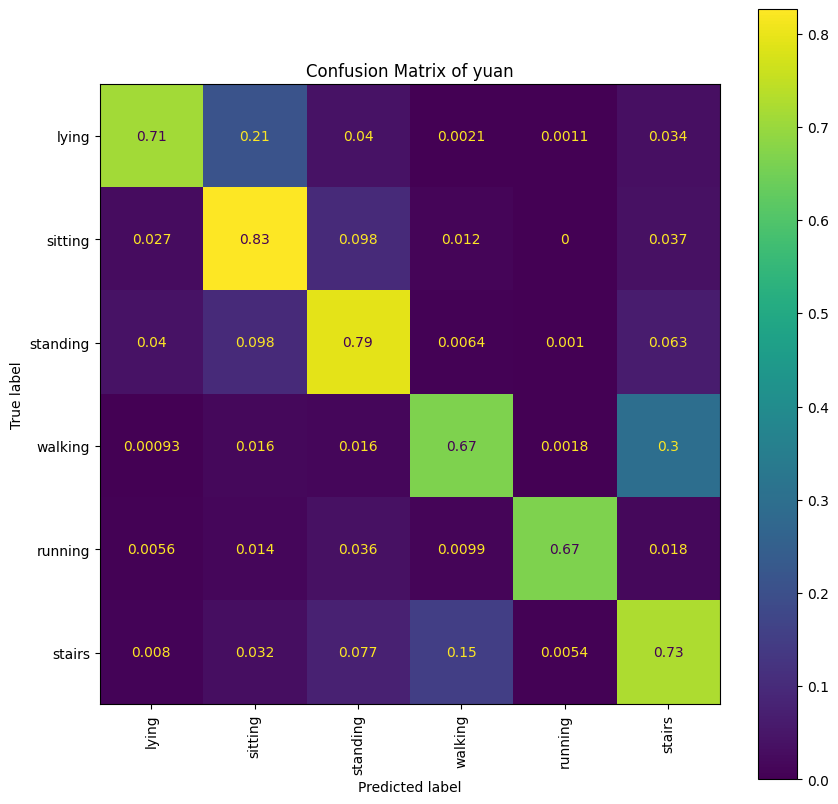

In [ ]:
classification_report(results_yuan, f_set='yuan')

In [ ]:
results_yaz = run(acc_data, f_set='yaz')

Accuracy: 0.7201207765682333
Precision: 0.7076787059996694
Recall: 0.7067113658284578
Cohen Kappa: 0.6531751505644595
F1 Score: 0.6930065058526632


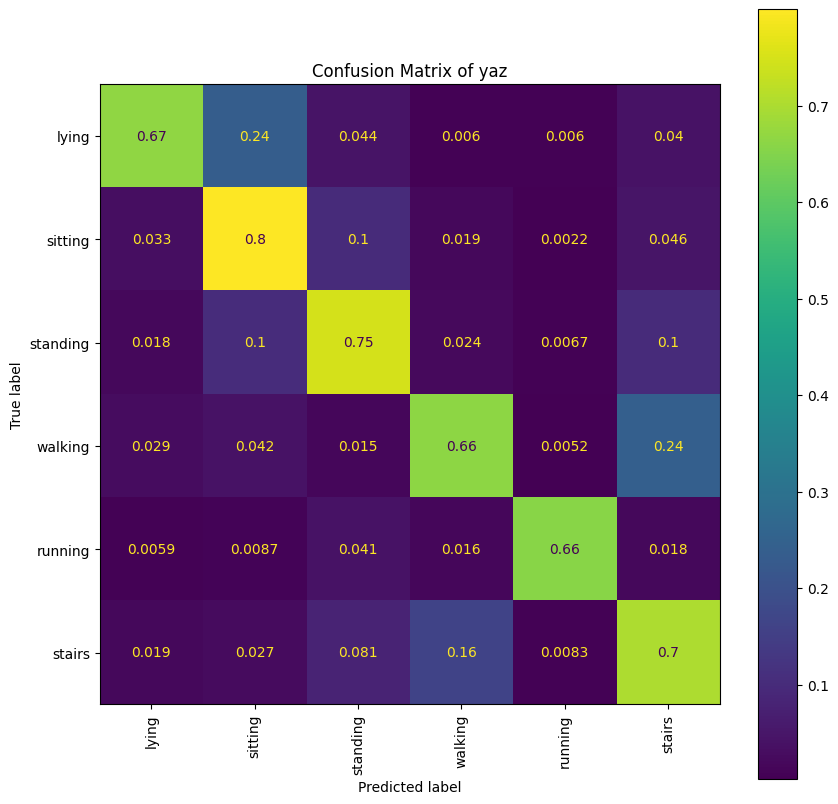

In [ ]:
classification_report(results_yaz, f_set='yaz')

In [ ]:
results_yuan_yaz = run(acc_data, f_set='yuan_yaz')

Accuracy: 0.7354407860882813
Precision: 0.7218173170661872
Recall: 0.7177284160225533
Cohen Kappa: 0.67169258383484
F1 Score: 0.7074656904105433


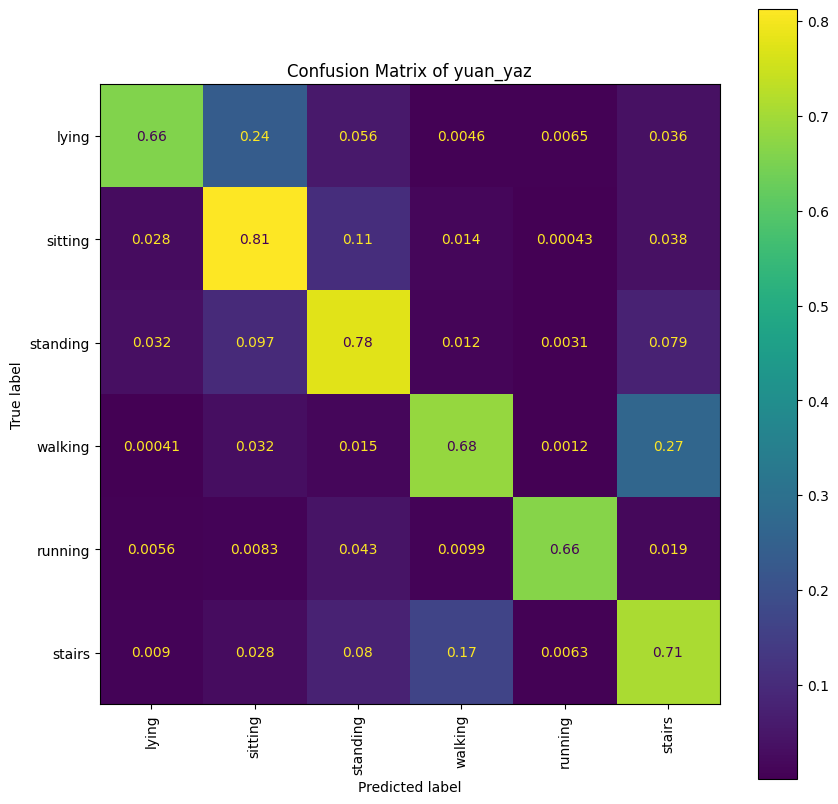

In [ ]:
classification_report(results_yuan_yaz, f_set='yuan_yaz')

## Serialize RF trained on all the accelerometer data

In [ ]:
# Local Env
# data_path = /dataset/pamap2_data
data_path = "drive/MyDrive/dataset/pamap2_data"
window_size = 1
acc_data = AccDataReader(data_path, window_size=1)

Reading subject101.dat
Reading subject102.dat
Reading subject103.dat
Reading subject104.dat
Reading subject105.dat
Reading subject106.dat
Reading subject107.dat
Reading subject109.dat
Reading subject108.dat
No data in subject109.dat


In [ ]:
# get random forest trained on all data
rf = rf_train_all_data(acc_data, f_set='yuan')

In [ ]:
from skl2onnx import to_onnx

onx = to_onnx(rf, acc_data.x_train[:1])
with open("rf_acc.onnx", "wb") as f:
    f.write(onx.SerializeToString())